In [1]:
from omegaconf import open_dict
from hydra import initialize, compose
from hydra.utils import get_original_cwd

import torch
import torchaudio
import torchaudio.functional as F

import numpy as np
import mne
import scipy
import matplotlib.pyplot as plt
import pandas as pd
# from pylab import rcParams
# rcParams['figure.figsize'] = (5, 3)

from speech_decoding.dataclass.brennan2018 import Brennan2018Dataset
from speech_decoding.utils.preproc_utils import (
    shift_brain_signal,
    continuous,
    baseline_correction,
    scale_and_clamp,
    pad_y_time,
    interpolate_y_time,
)
from speech_decoding.constants import BRAIN_RESAMPLE_RATE, AUDIO_RESAMPLE_RATE

/home/sensho/anaconda3/envs/speech_decoding/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with initialize(version_base=None, config_path="../configs"):
    args = compose(config_name='config.yaml')
    
with open_dict(args):
    args.root_dir = "/home/sensho/speech_decoding"
    args.dataset = "Brennan2018"

In [3]:
dataset = Brennan2018Dataset(args)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_q.weight', 'quantizer.weight_proj.weight', 'project_hid.bias', 'project_q.bias', 'project_hid.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


> Using pre-processed EEG torch.Size([1717, 33, 60, 360]) | srate=120
> Using pre-processed audio embeddings torch.Size([1717, 1024, 149])
>>> Number of subjects: 33
>> Upsampling audio embedding with: interpolate


# Audio resampling (16kHz)

In [13]:
waveform = [torchaudio.load(path) for path in dataset.audio_paths]

sample_rate = dataset.get_audio_rate(waveform)
print(sample_rate)

waveform = torch.cat([w[0] for w in waveform], dim=1)
print(waveform.shape)

44100
torch.Size([1, 31908132])


In [20]:
audio = dataset.resample_audio(waveform, sample_rate)

>>> Audio length: 723.5404375 s.


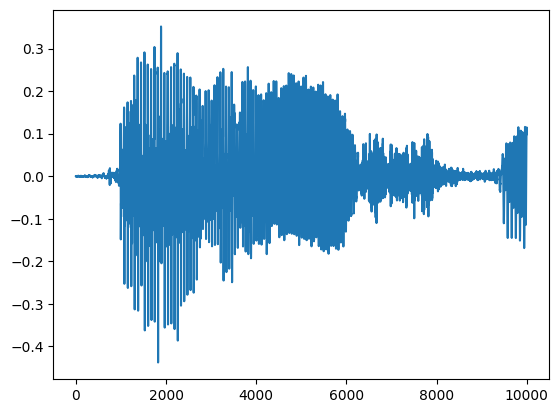

In [6]:
plt.plot(audio[0, :10000])

# EEG filtering & resampling (120Hz)

In [4]:
EXCLUDED_SUBJECTS = [
    "S02", "S07", "S09", "S23", "S24", "S27", "S28", "S29", "S30", "S31",
    "S32", "S33", "S43", "S46", "S47", "S49",
]

matfile_paths = [
    path for path in dataset.matfile_paths if not path.split(".")[0][-3:] in EXCLUDED_SUBJECTS
]
mat_raws = [scipy.io.loadmat(path)["raw"][0, 0] for path in matfile_paths]
eeg_raws = [mat_raw["trial"][0, 0] for mat_raw in mat_raws]

trim_eeg_to = min([eeg_raw.shape[1] for eeg_raw in eeg_raws])
print(trim_eeg_to)

363325


In [5]:
def plot_channels(eeg):
    fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(20, 20), tight_layout=True)
    for i, ax in enumerate(axes.flatten()):
        ax.plot(eeg[i])
        ax.set_title(f"Channel {i+1}")

## Testing with S01

In [6]:
eeg_raw = eeg_raws[0]
print(eeg_raw.shape)

(62, 366525)


### Drop non-EEG channels and trim to the shortest subject

(60, 363325)


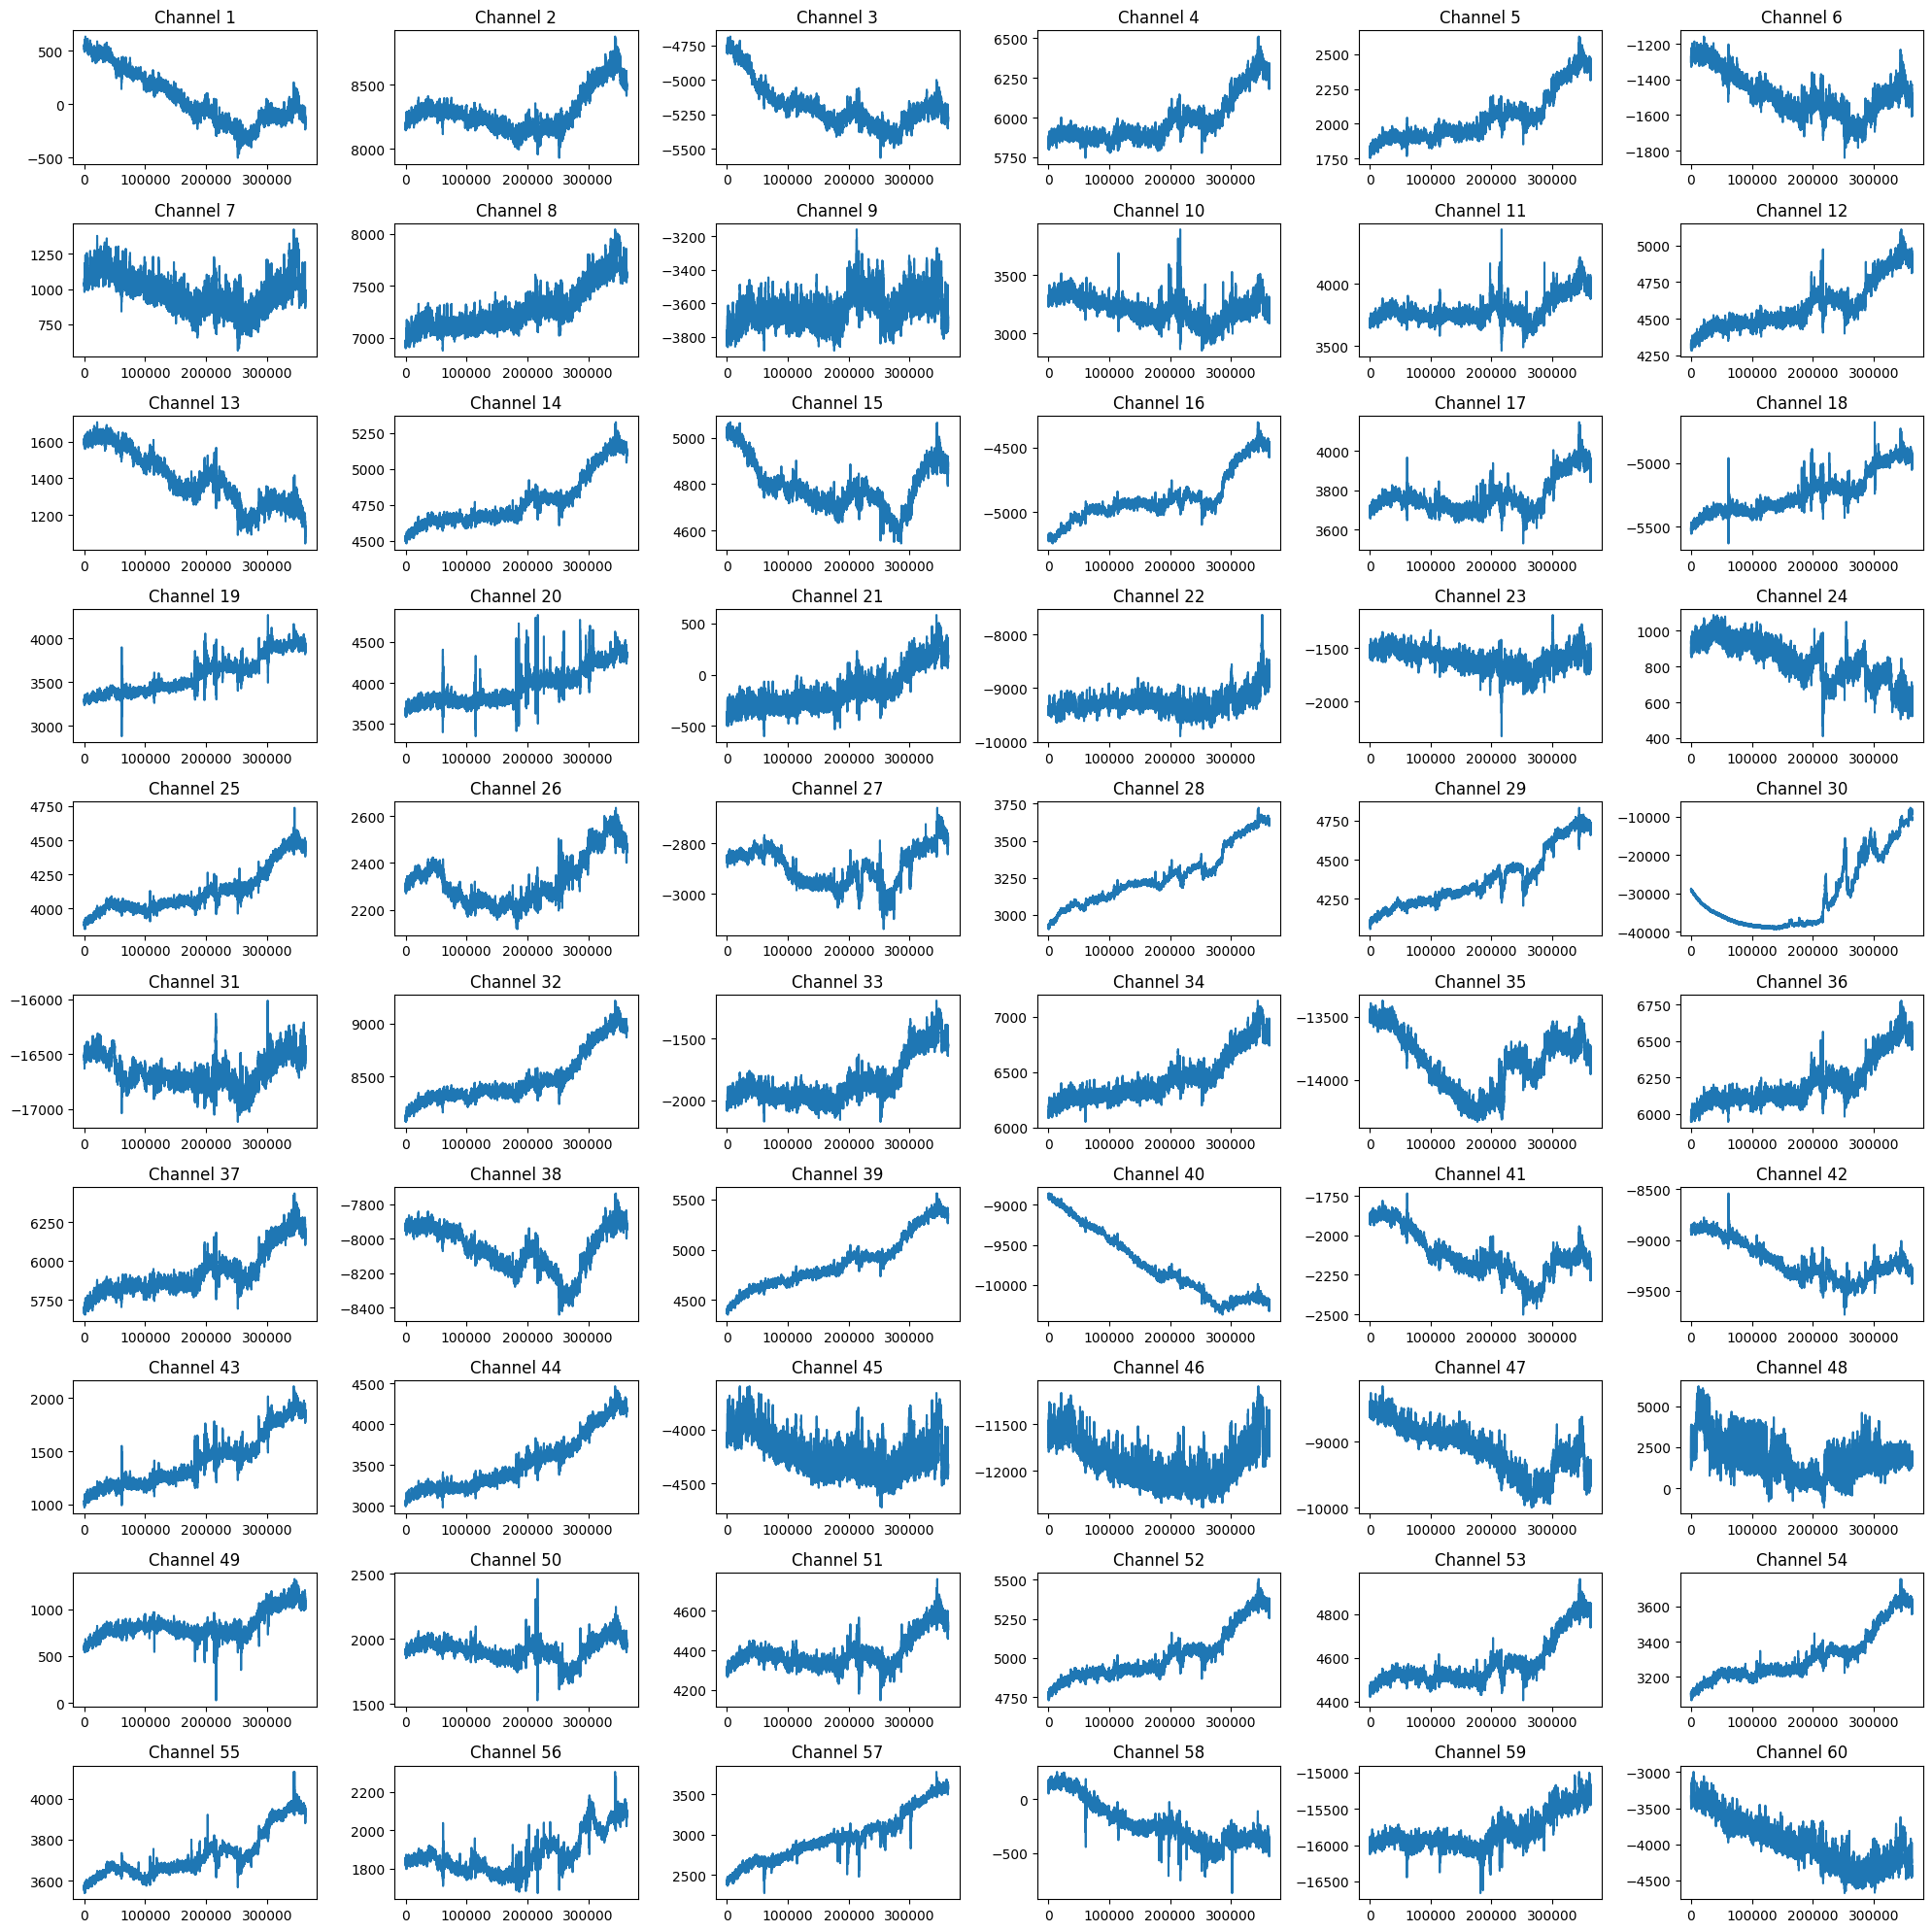

In [7]:
eeg_raw = eeg_raw[:60, :trim_eeg_to]
print(eeg_raw.shape)
plot_channels(eeg_raw)

### Filtering

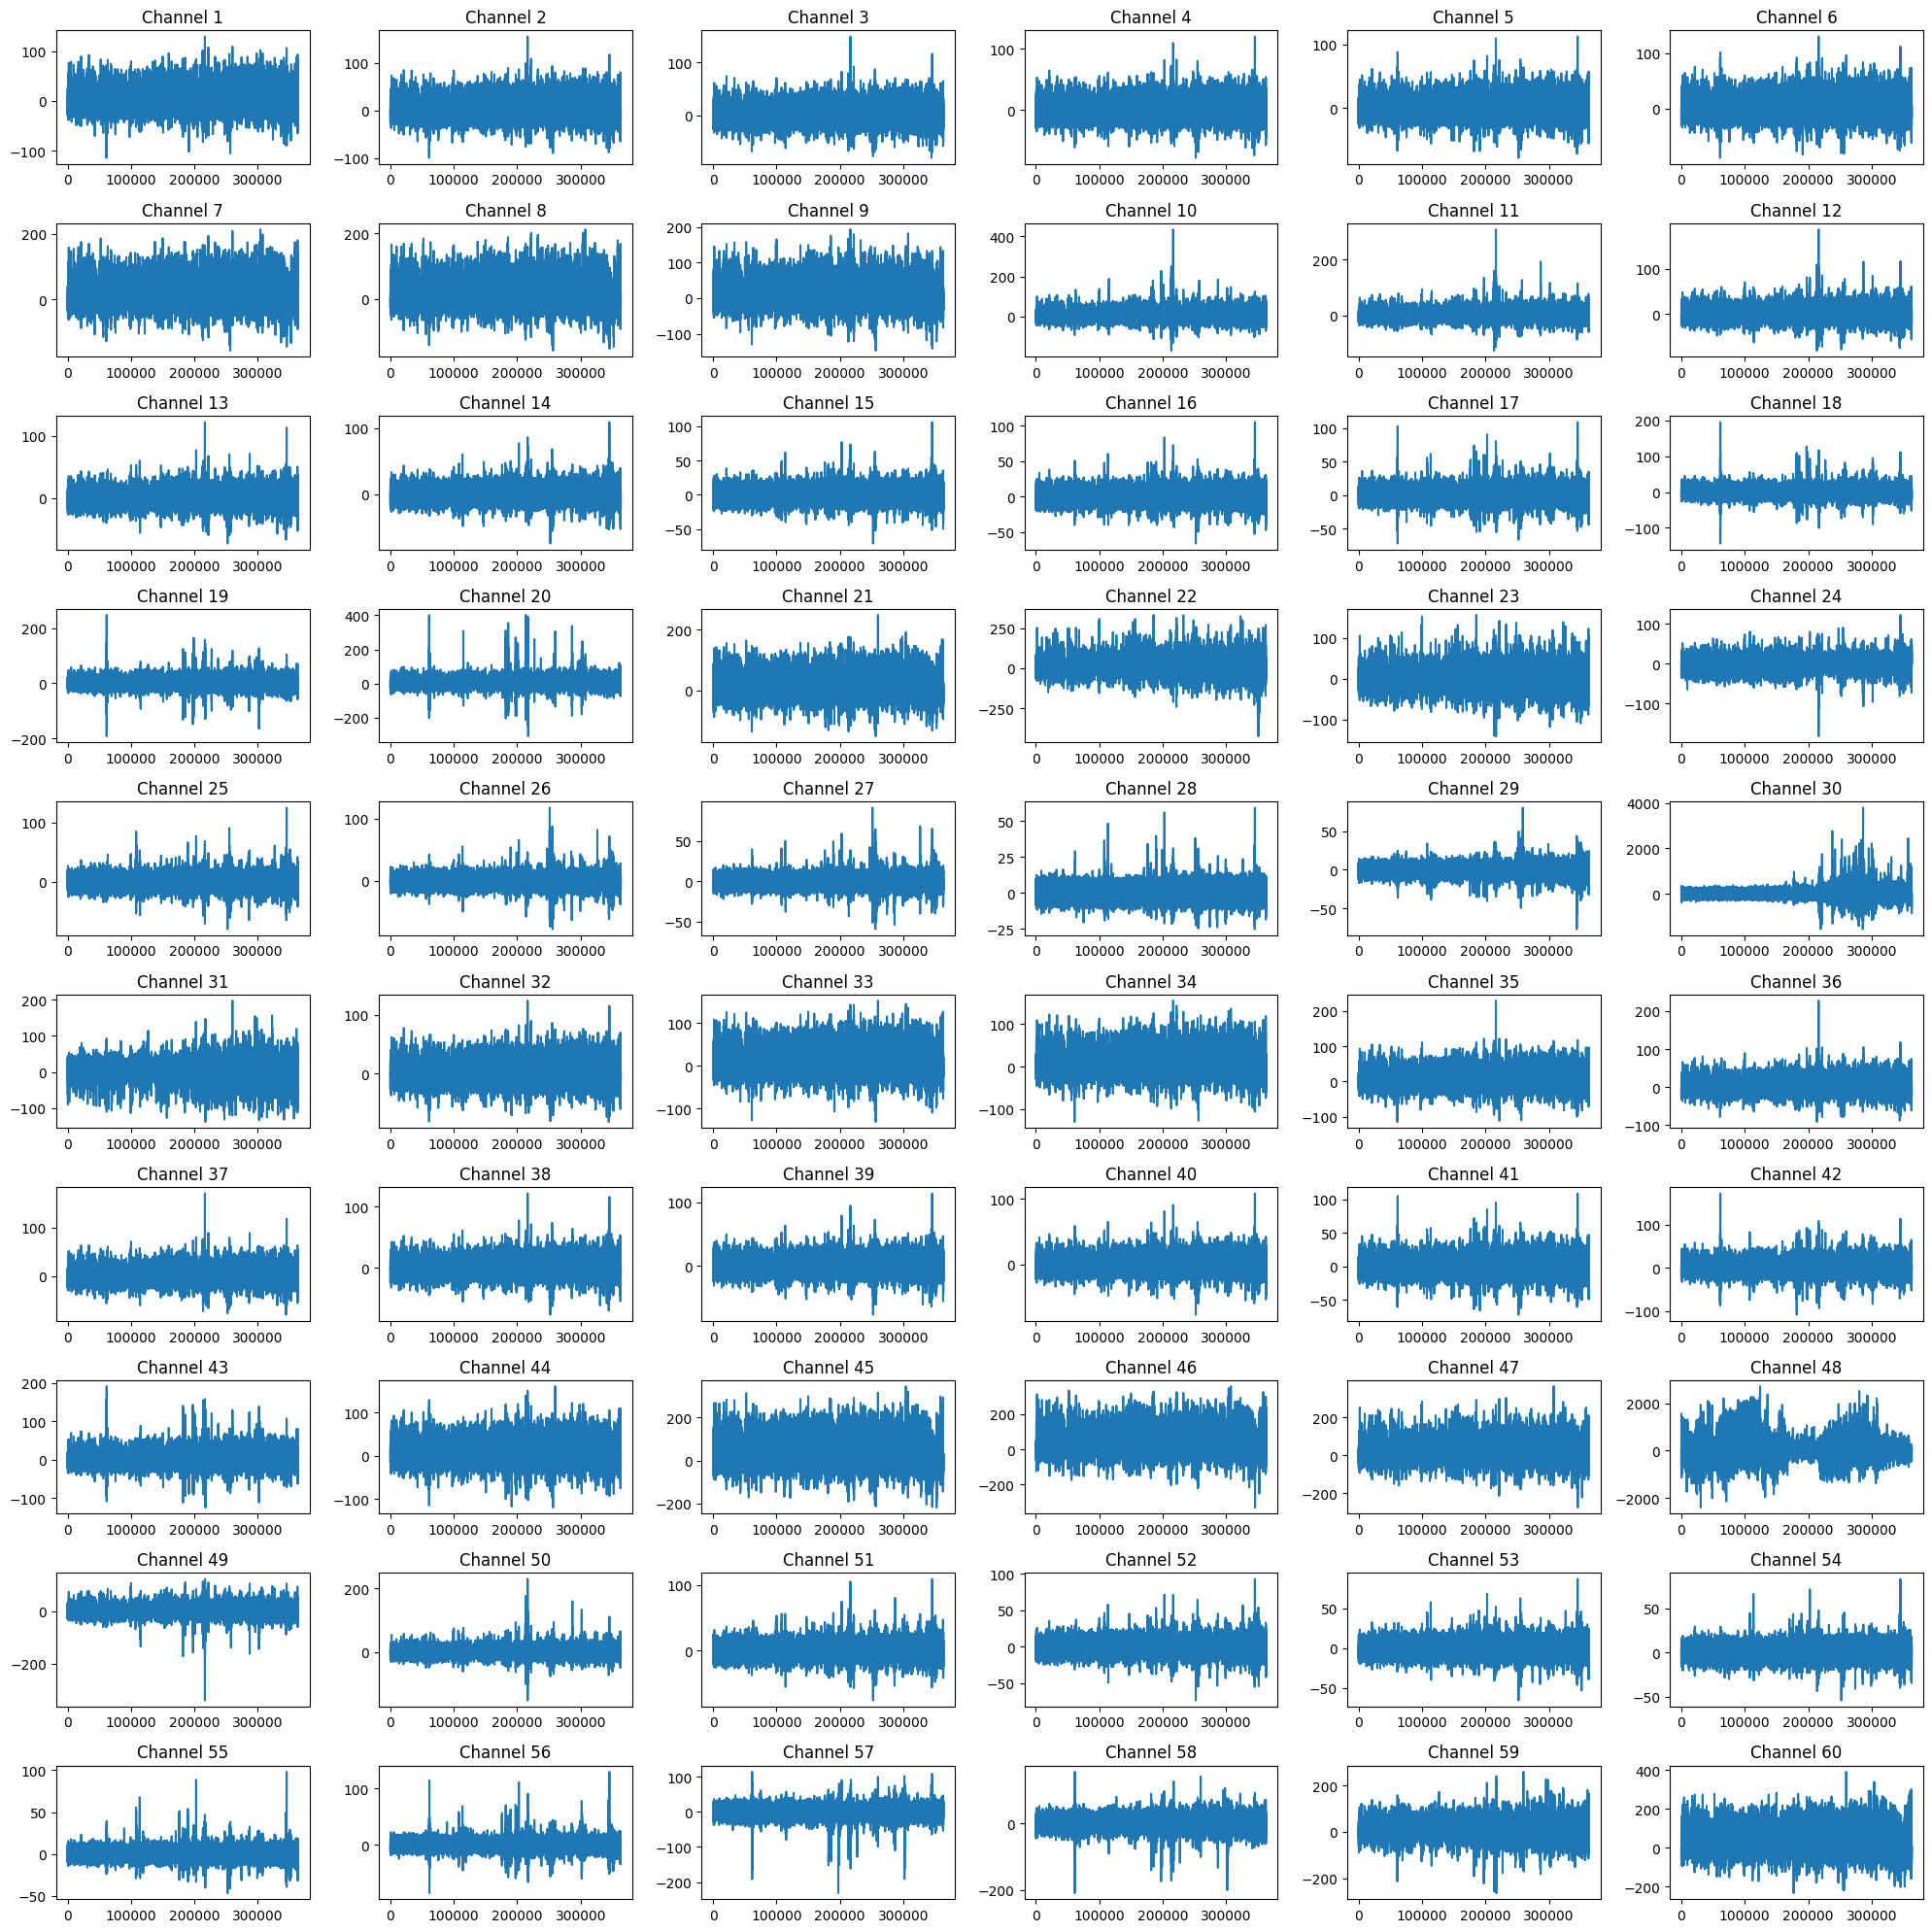

In [8]:
fsample = dataset.get_eeg_rate(mat_raws)

eeg_filtered = mne.filter.filter_data(
    eeg_raw,
    sfreq=fsample,
    l_freq=dataset.brain_filter_low,
    h_freq=dataset.brain_filter_high,
)
plot_channels(eeg_filtered)

### Resampling

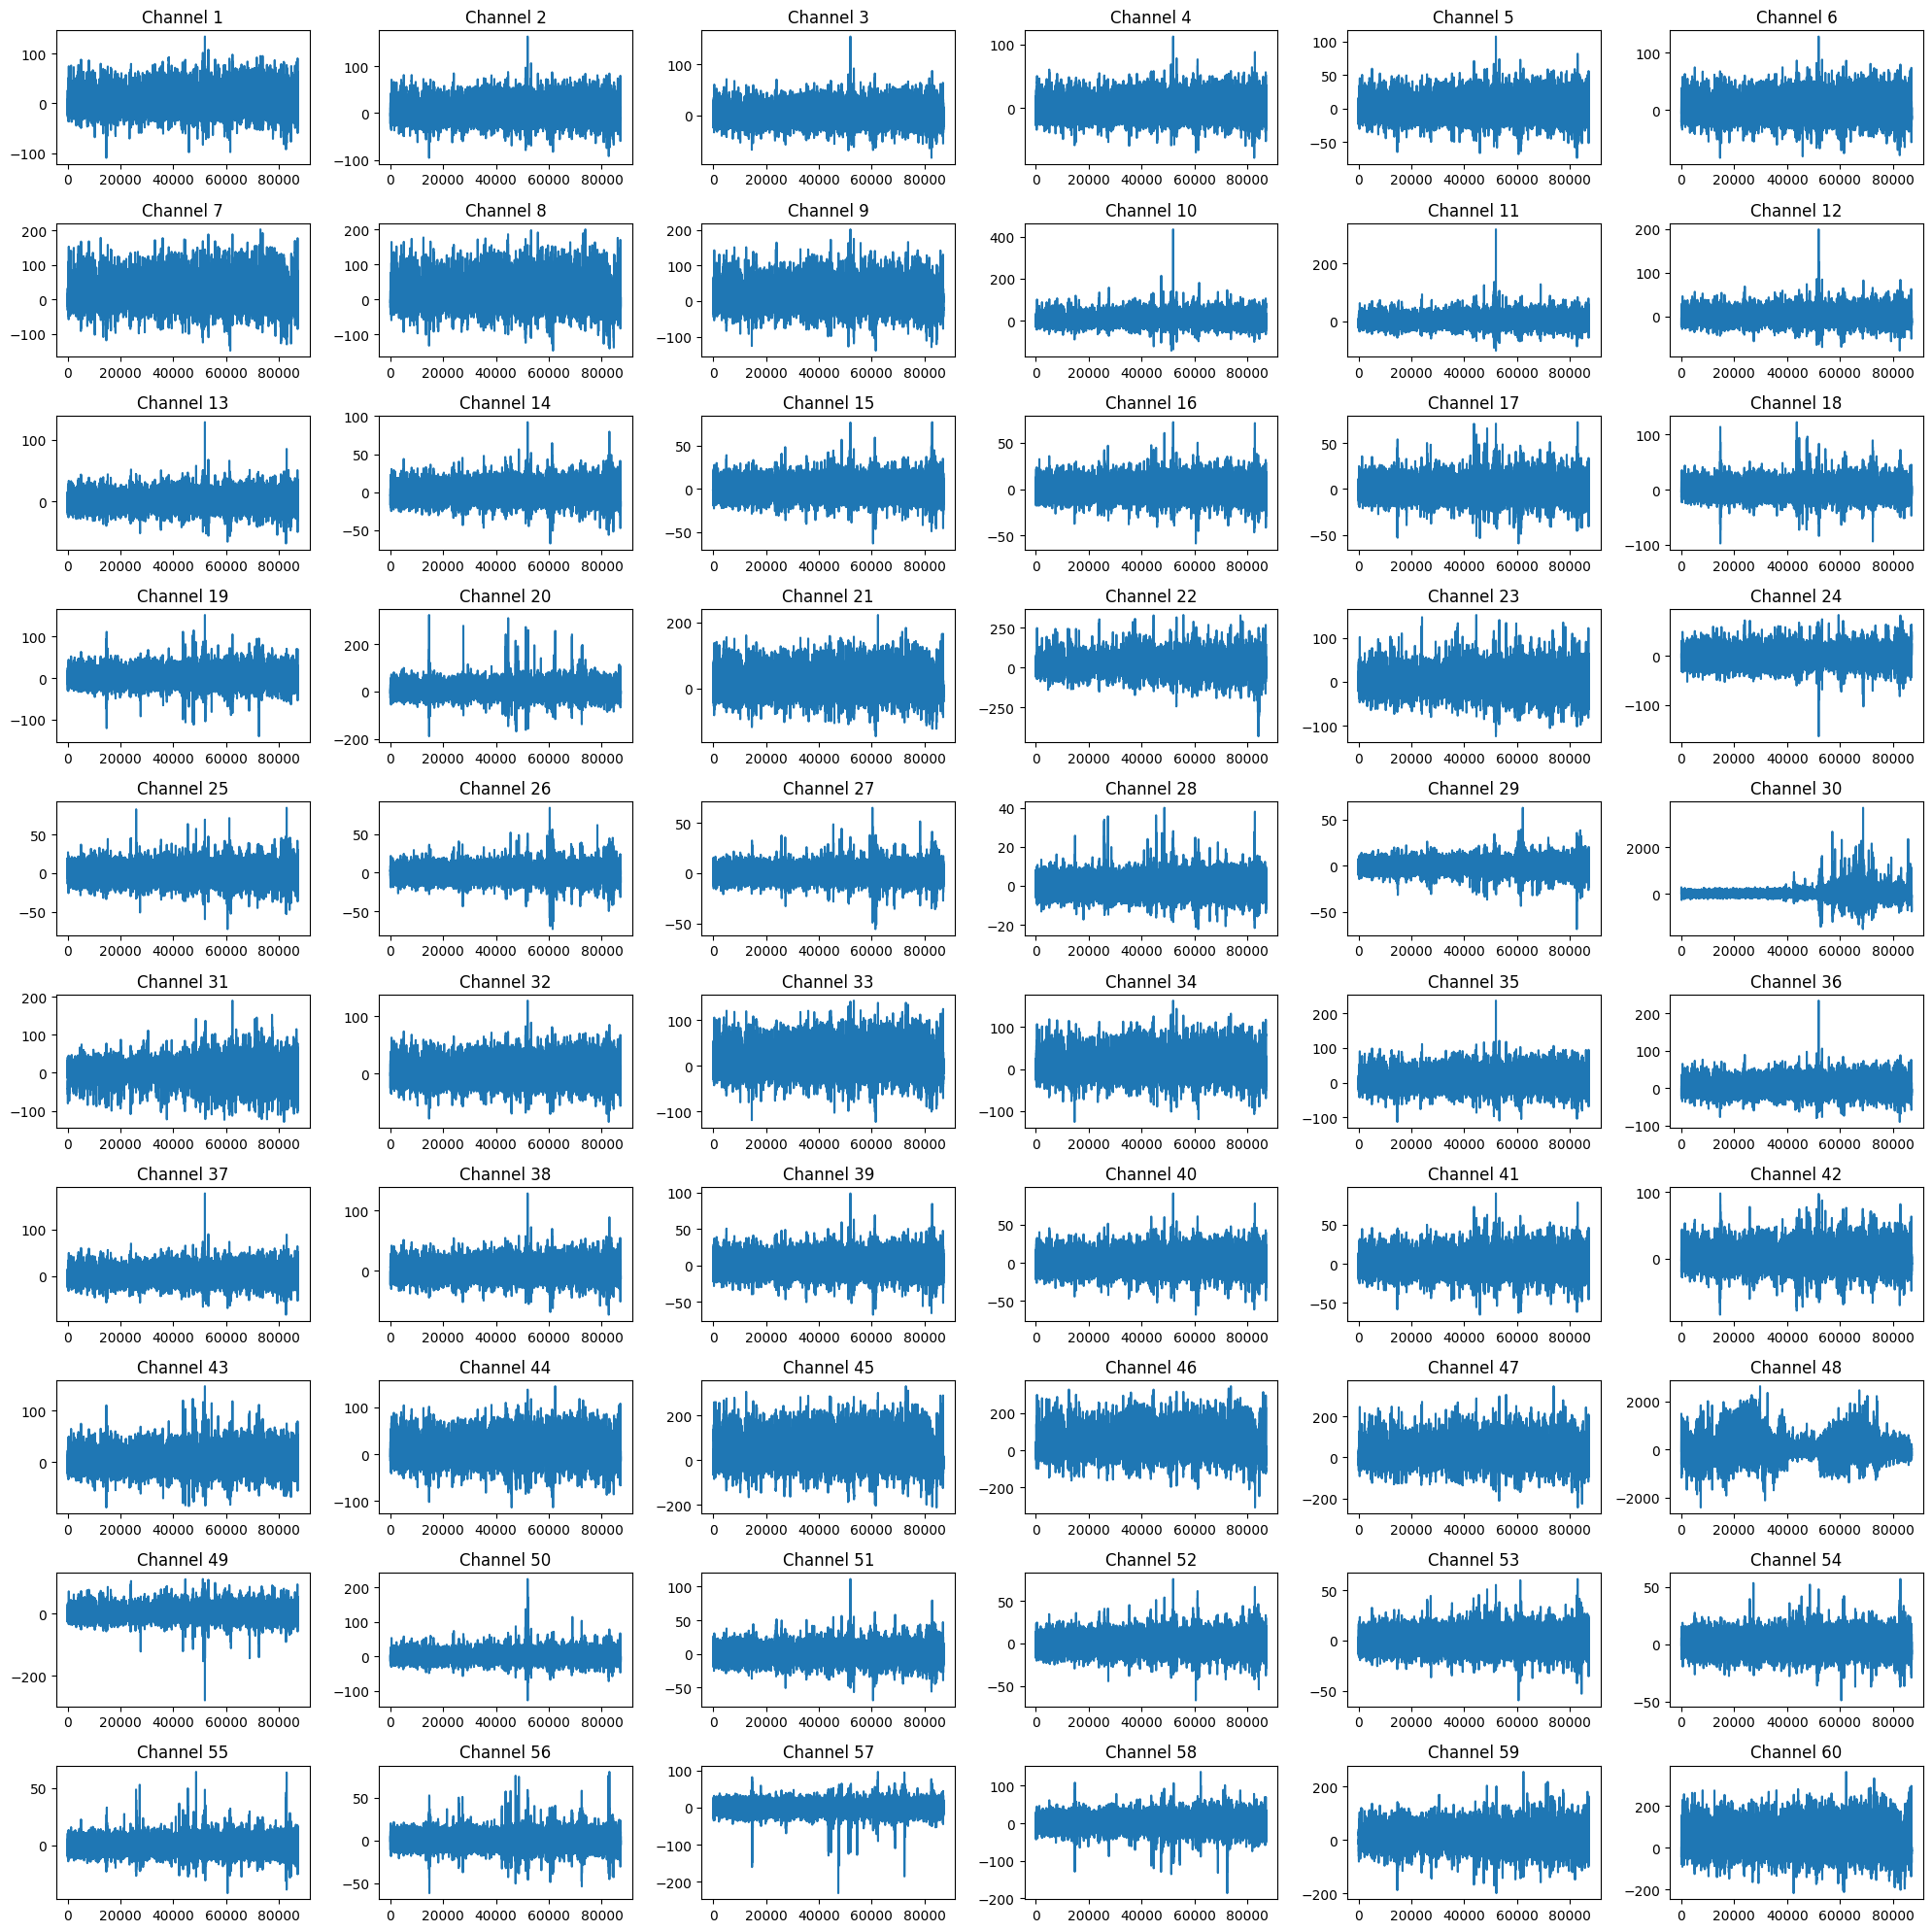

In [9]:
eeg_resampled = F.resample(
    waveform=torch.from_numpy(eeg_filtered.astype(np.float32)),
    orig_freq=fsample,
    new_freq=BRAIN_RESAMPLE_RATE,
    lowpass_filter_width=dataset.lowpass_filter_width,  # TODO: check
)
plot_channels(eeg_resampled)

# Preprocessing

In [21]:
X = eeg_resampled.unsqueeze(0)

## Shifting

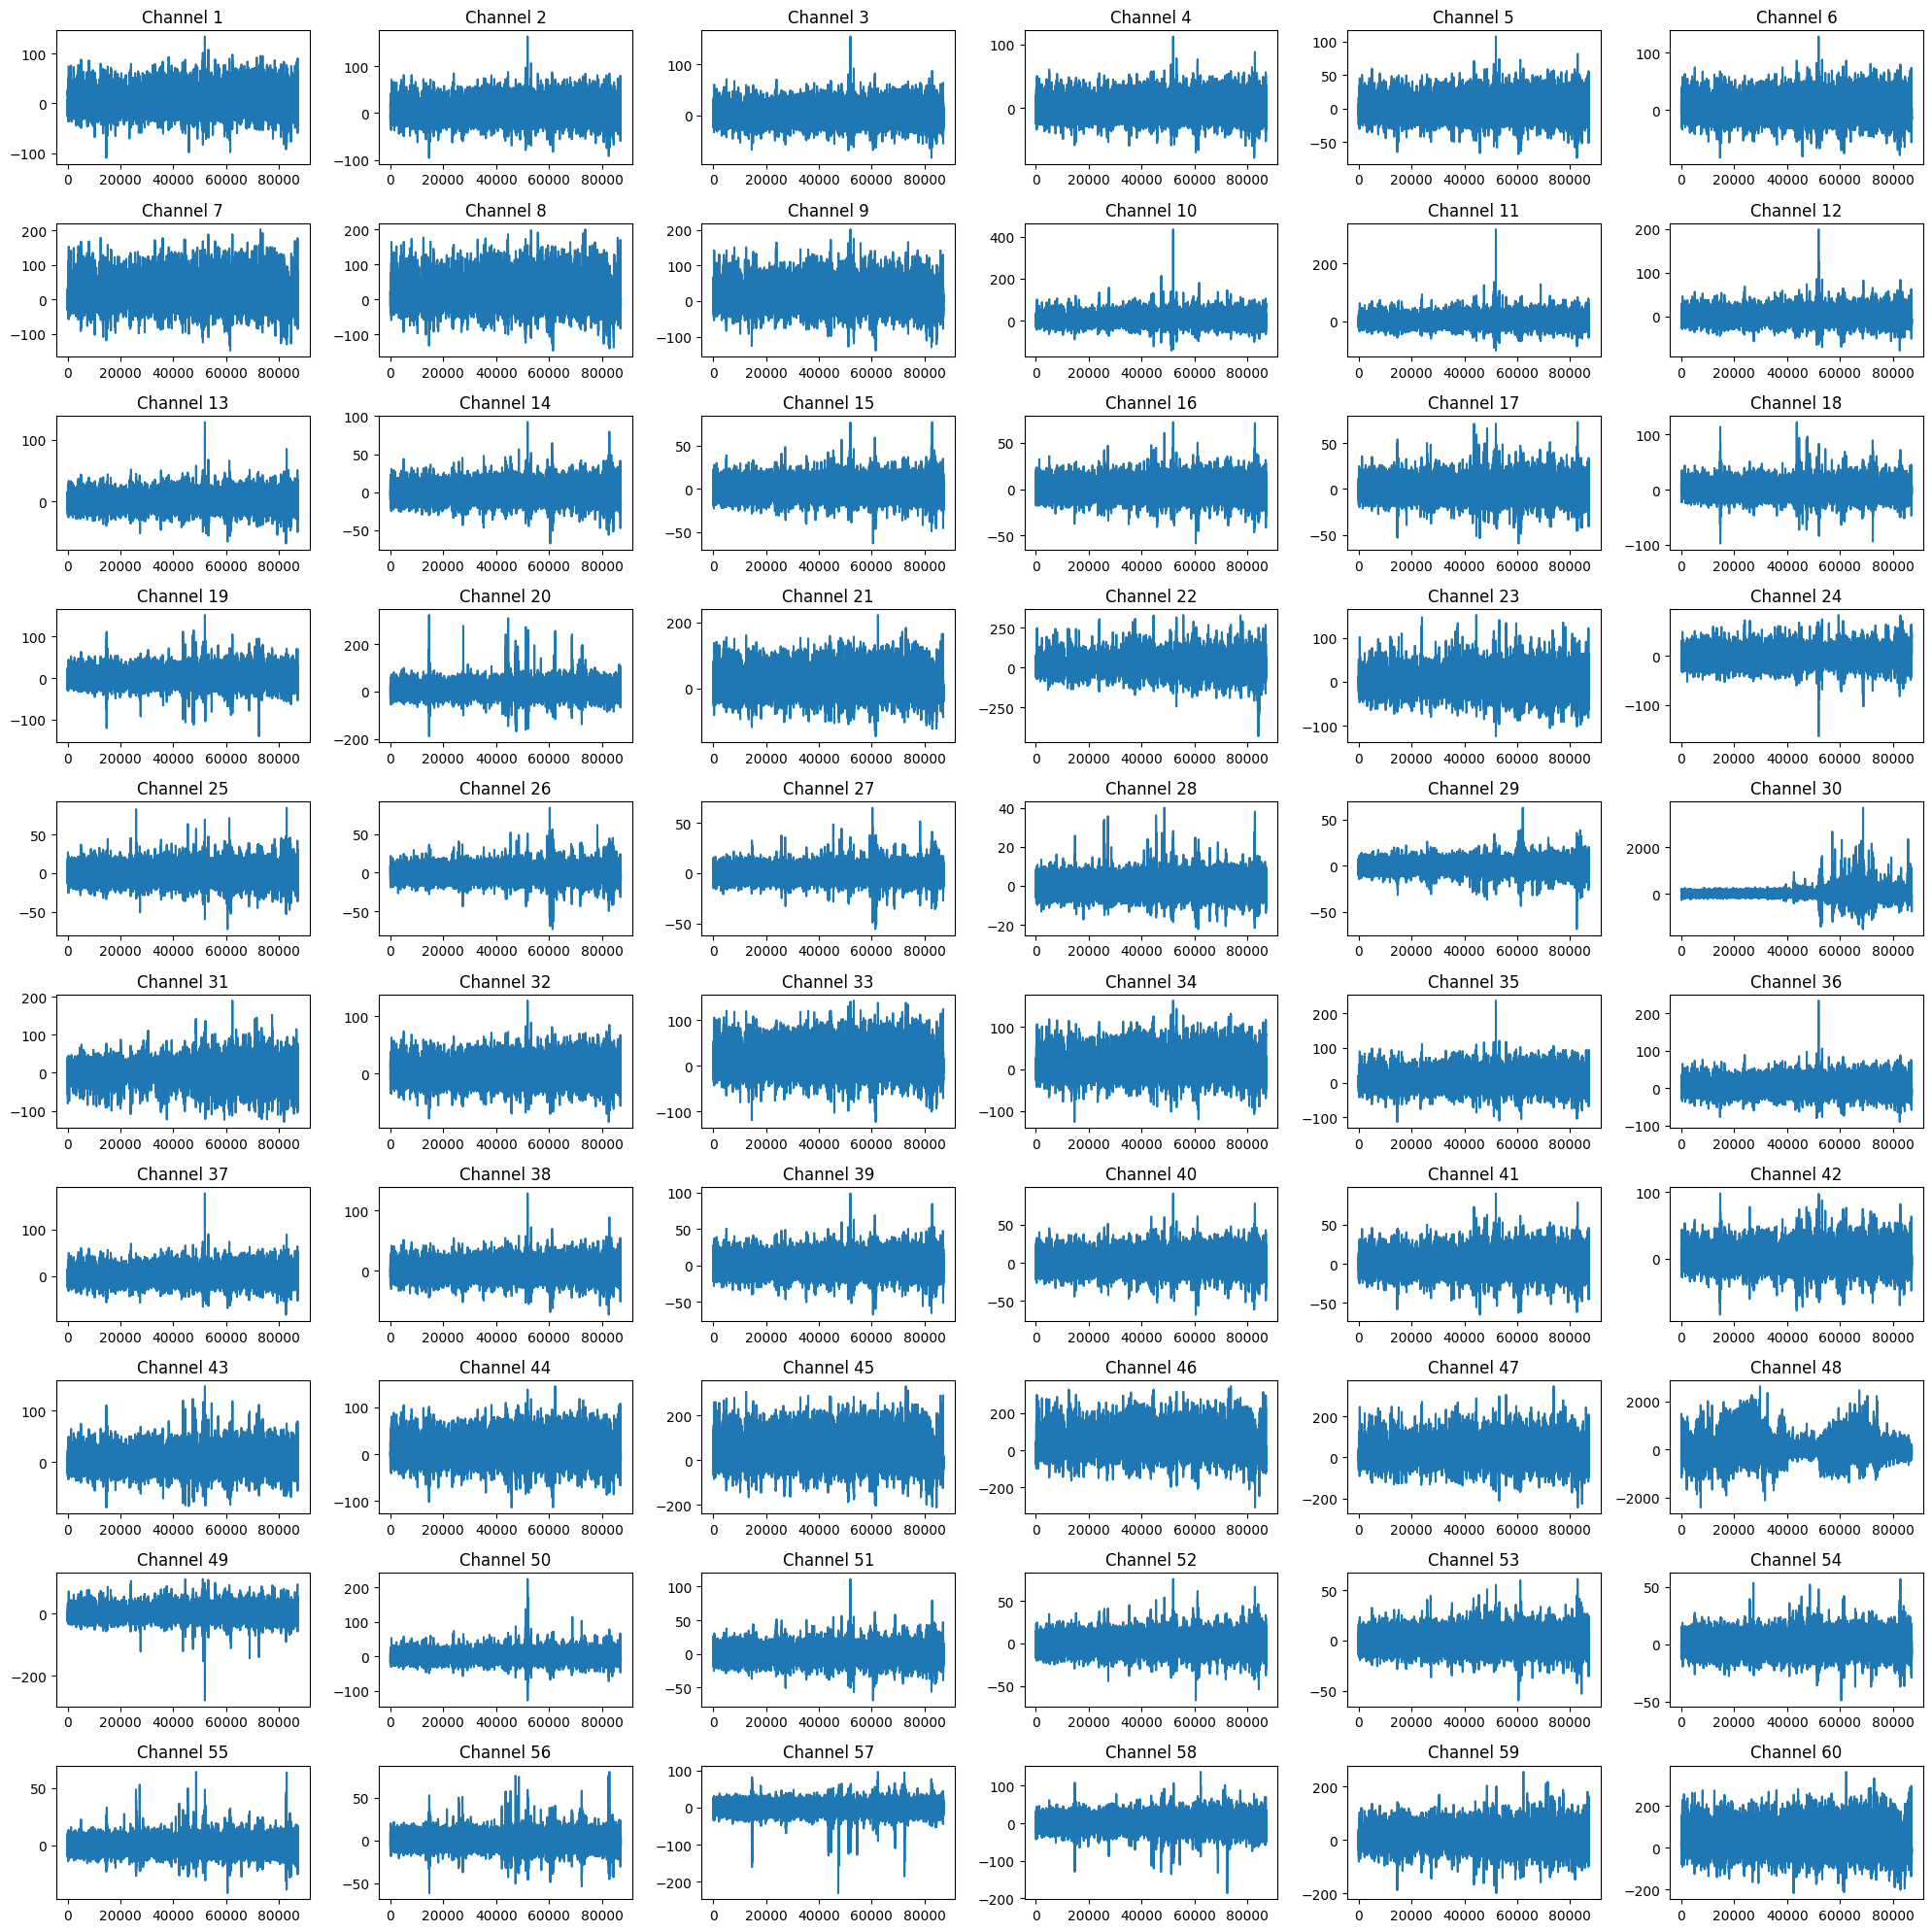

In [22]:
X, audio = shift_brain_signal(
    X, audio, srate_x=BRAIN_RESAMPLE_RATE, srate_y=AUDIO_RESAMPLE_RATE
)
plot_channels(X.squeeze())

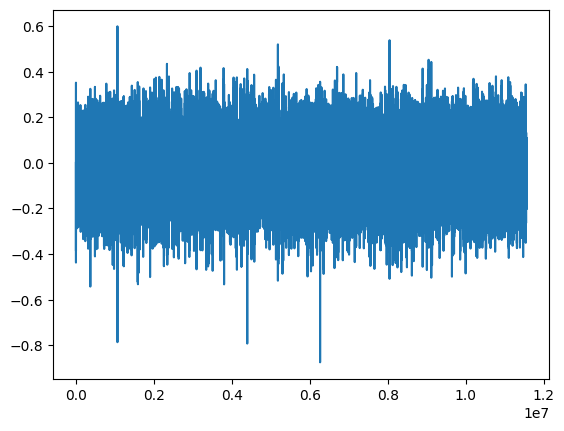

In [17]:
plt.plot(audio.squeeze())

## Segmenting

In [23]:
X, audio = dataset.segment(X, audio, dataset.onsets_path)
print(X.shape, audio.shape)

torch.Size([2129, 1, 60, 360]) torch.Size([2129, 1, 48000])


### Check segment 1

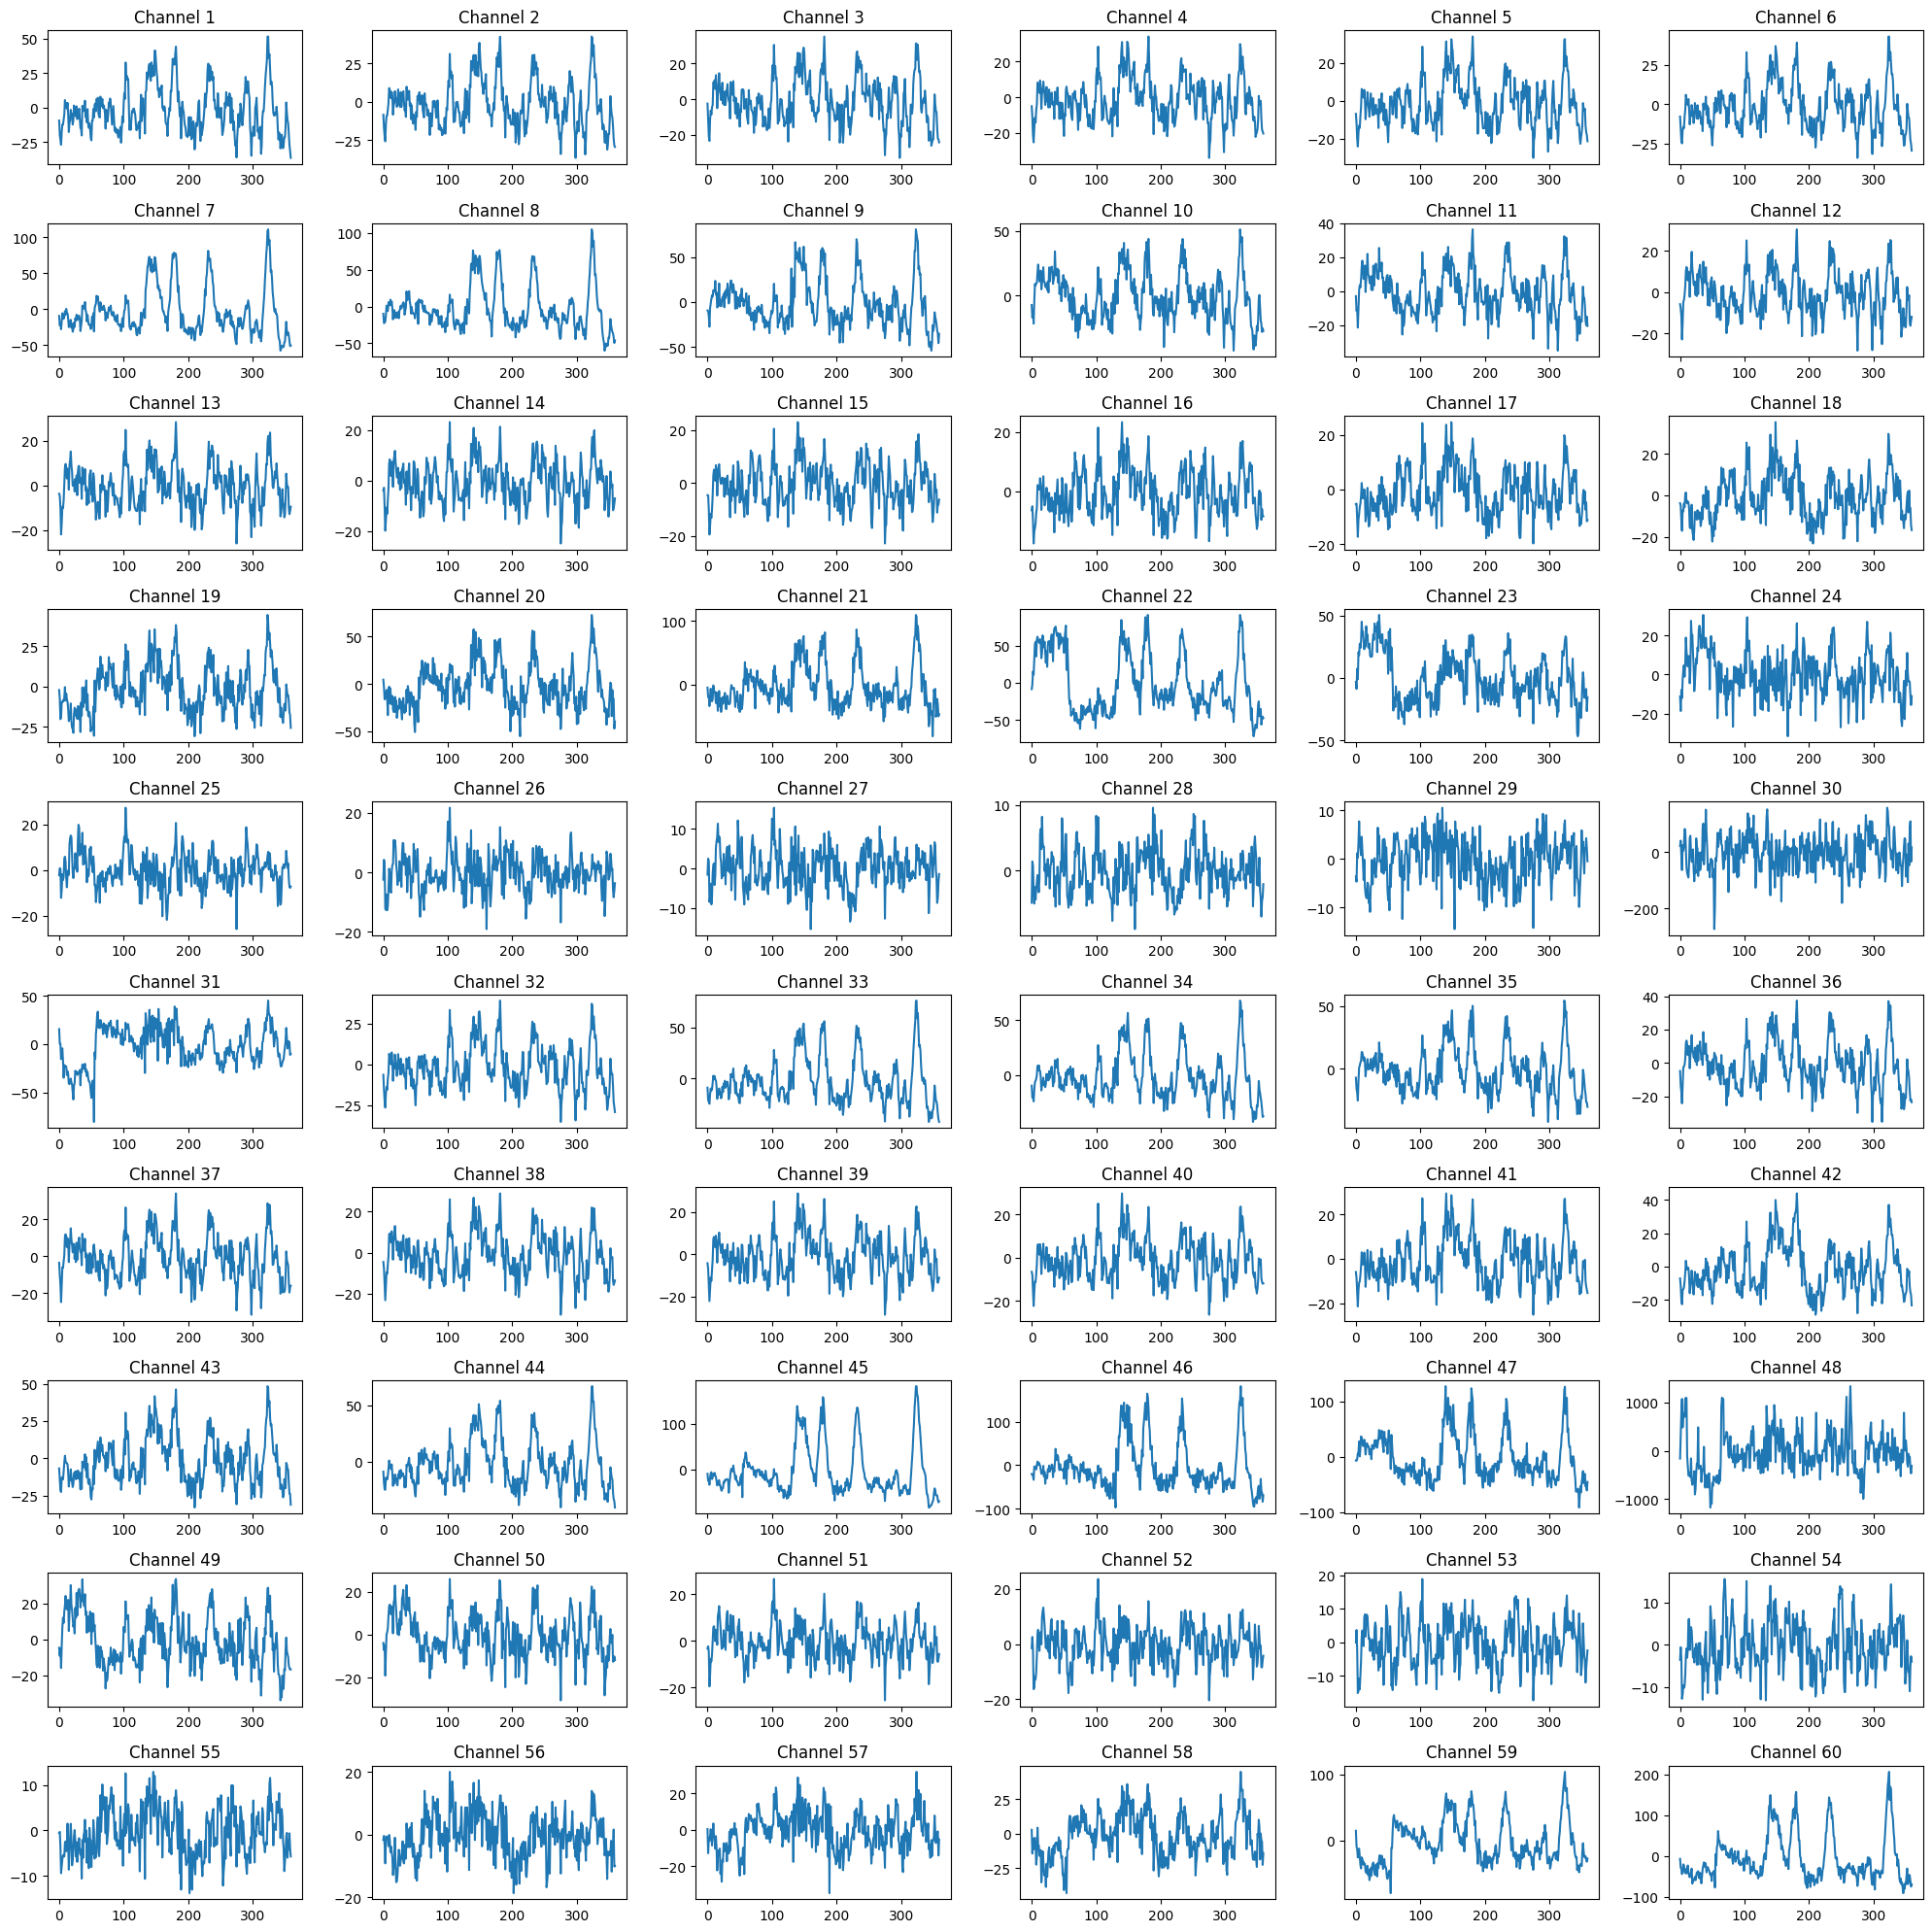

In [20]:
plot_channels(X[0].squeeze())

## Baseline correction

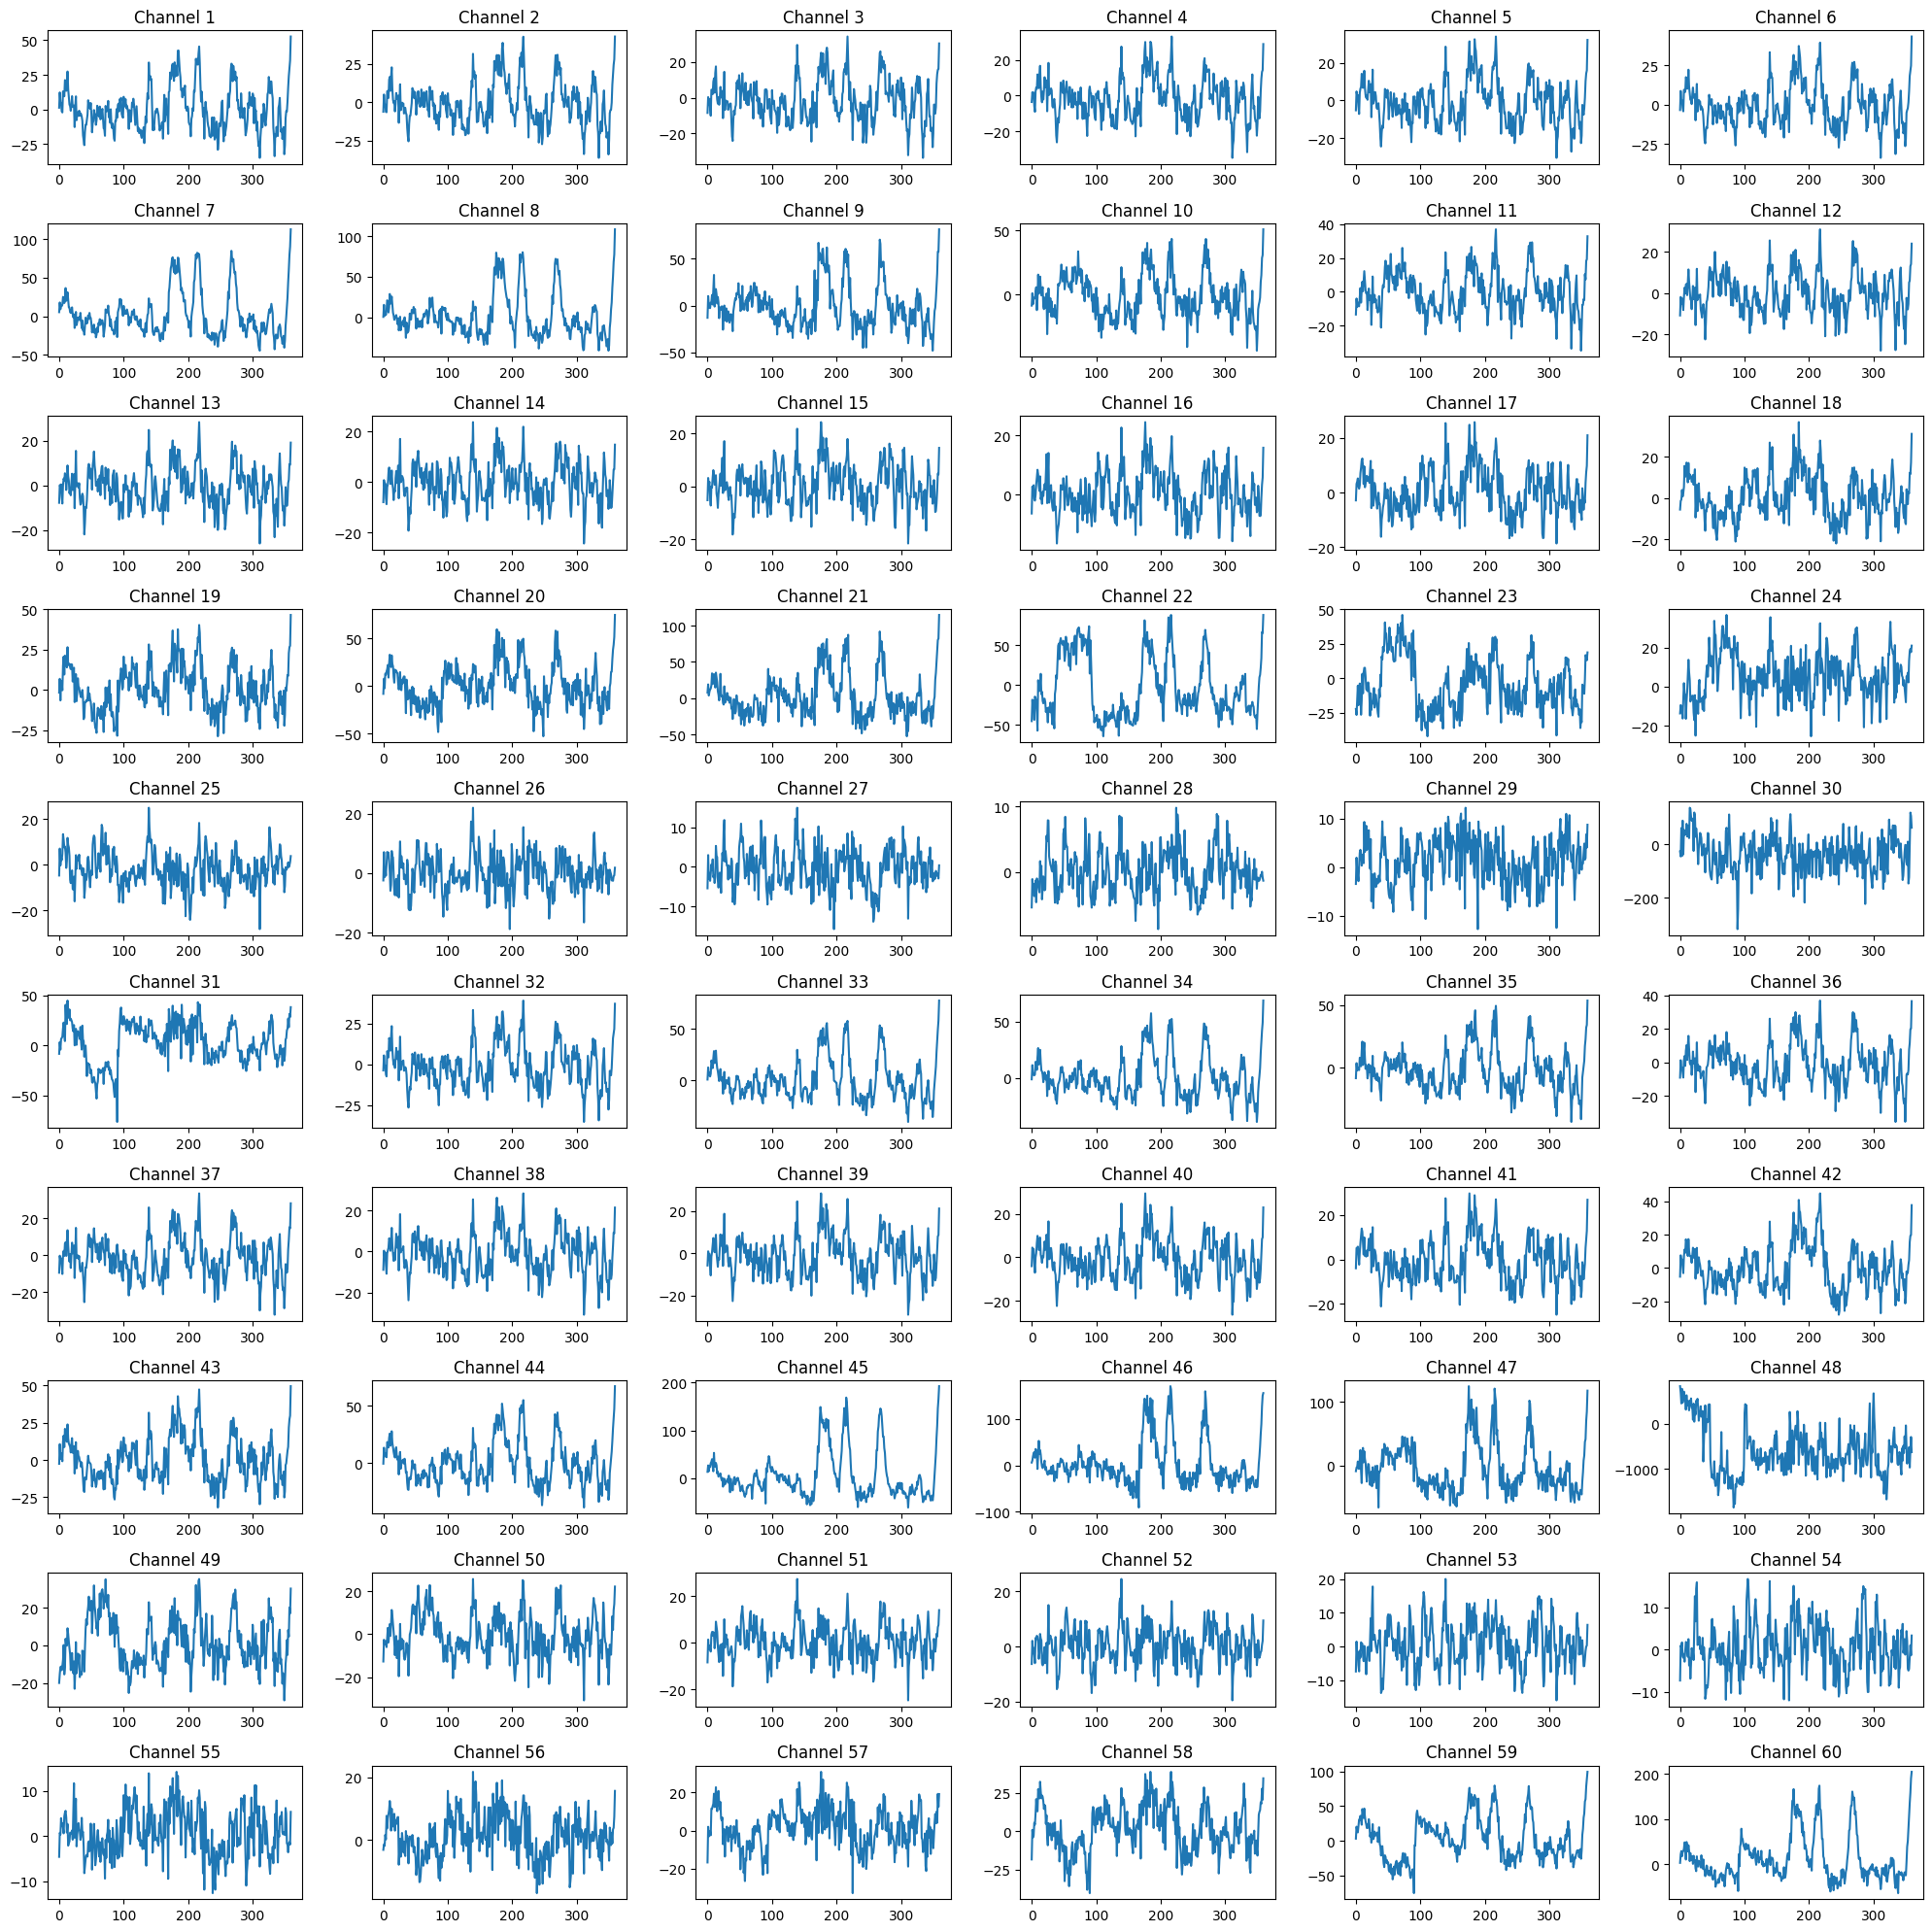

In [24]:
X = baseline_correction(X, dataset.baseline_num_samples)

plot_channels(X[0].squeeze())

## Scaling and clamping

100%|██████████| 2129/2129 [00:06<00:00, 318.97it/s]


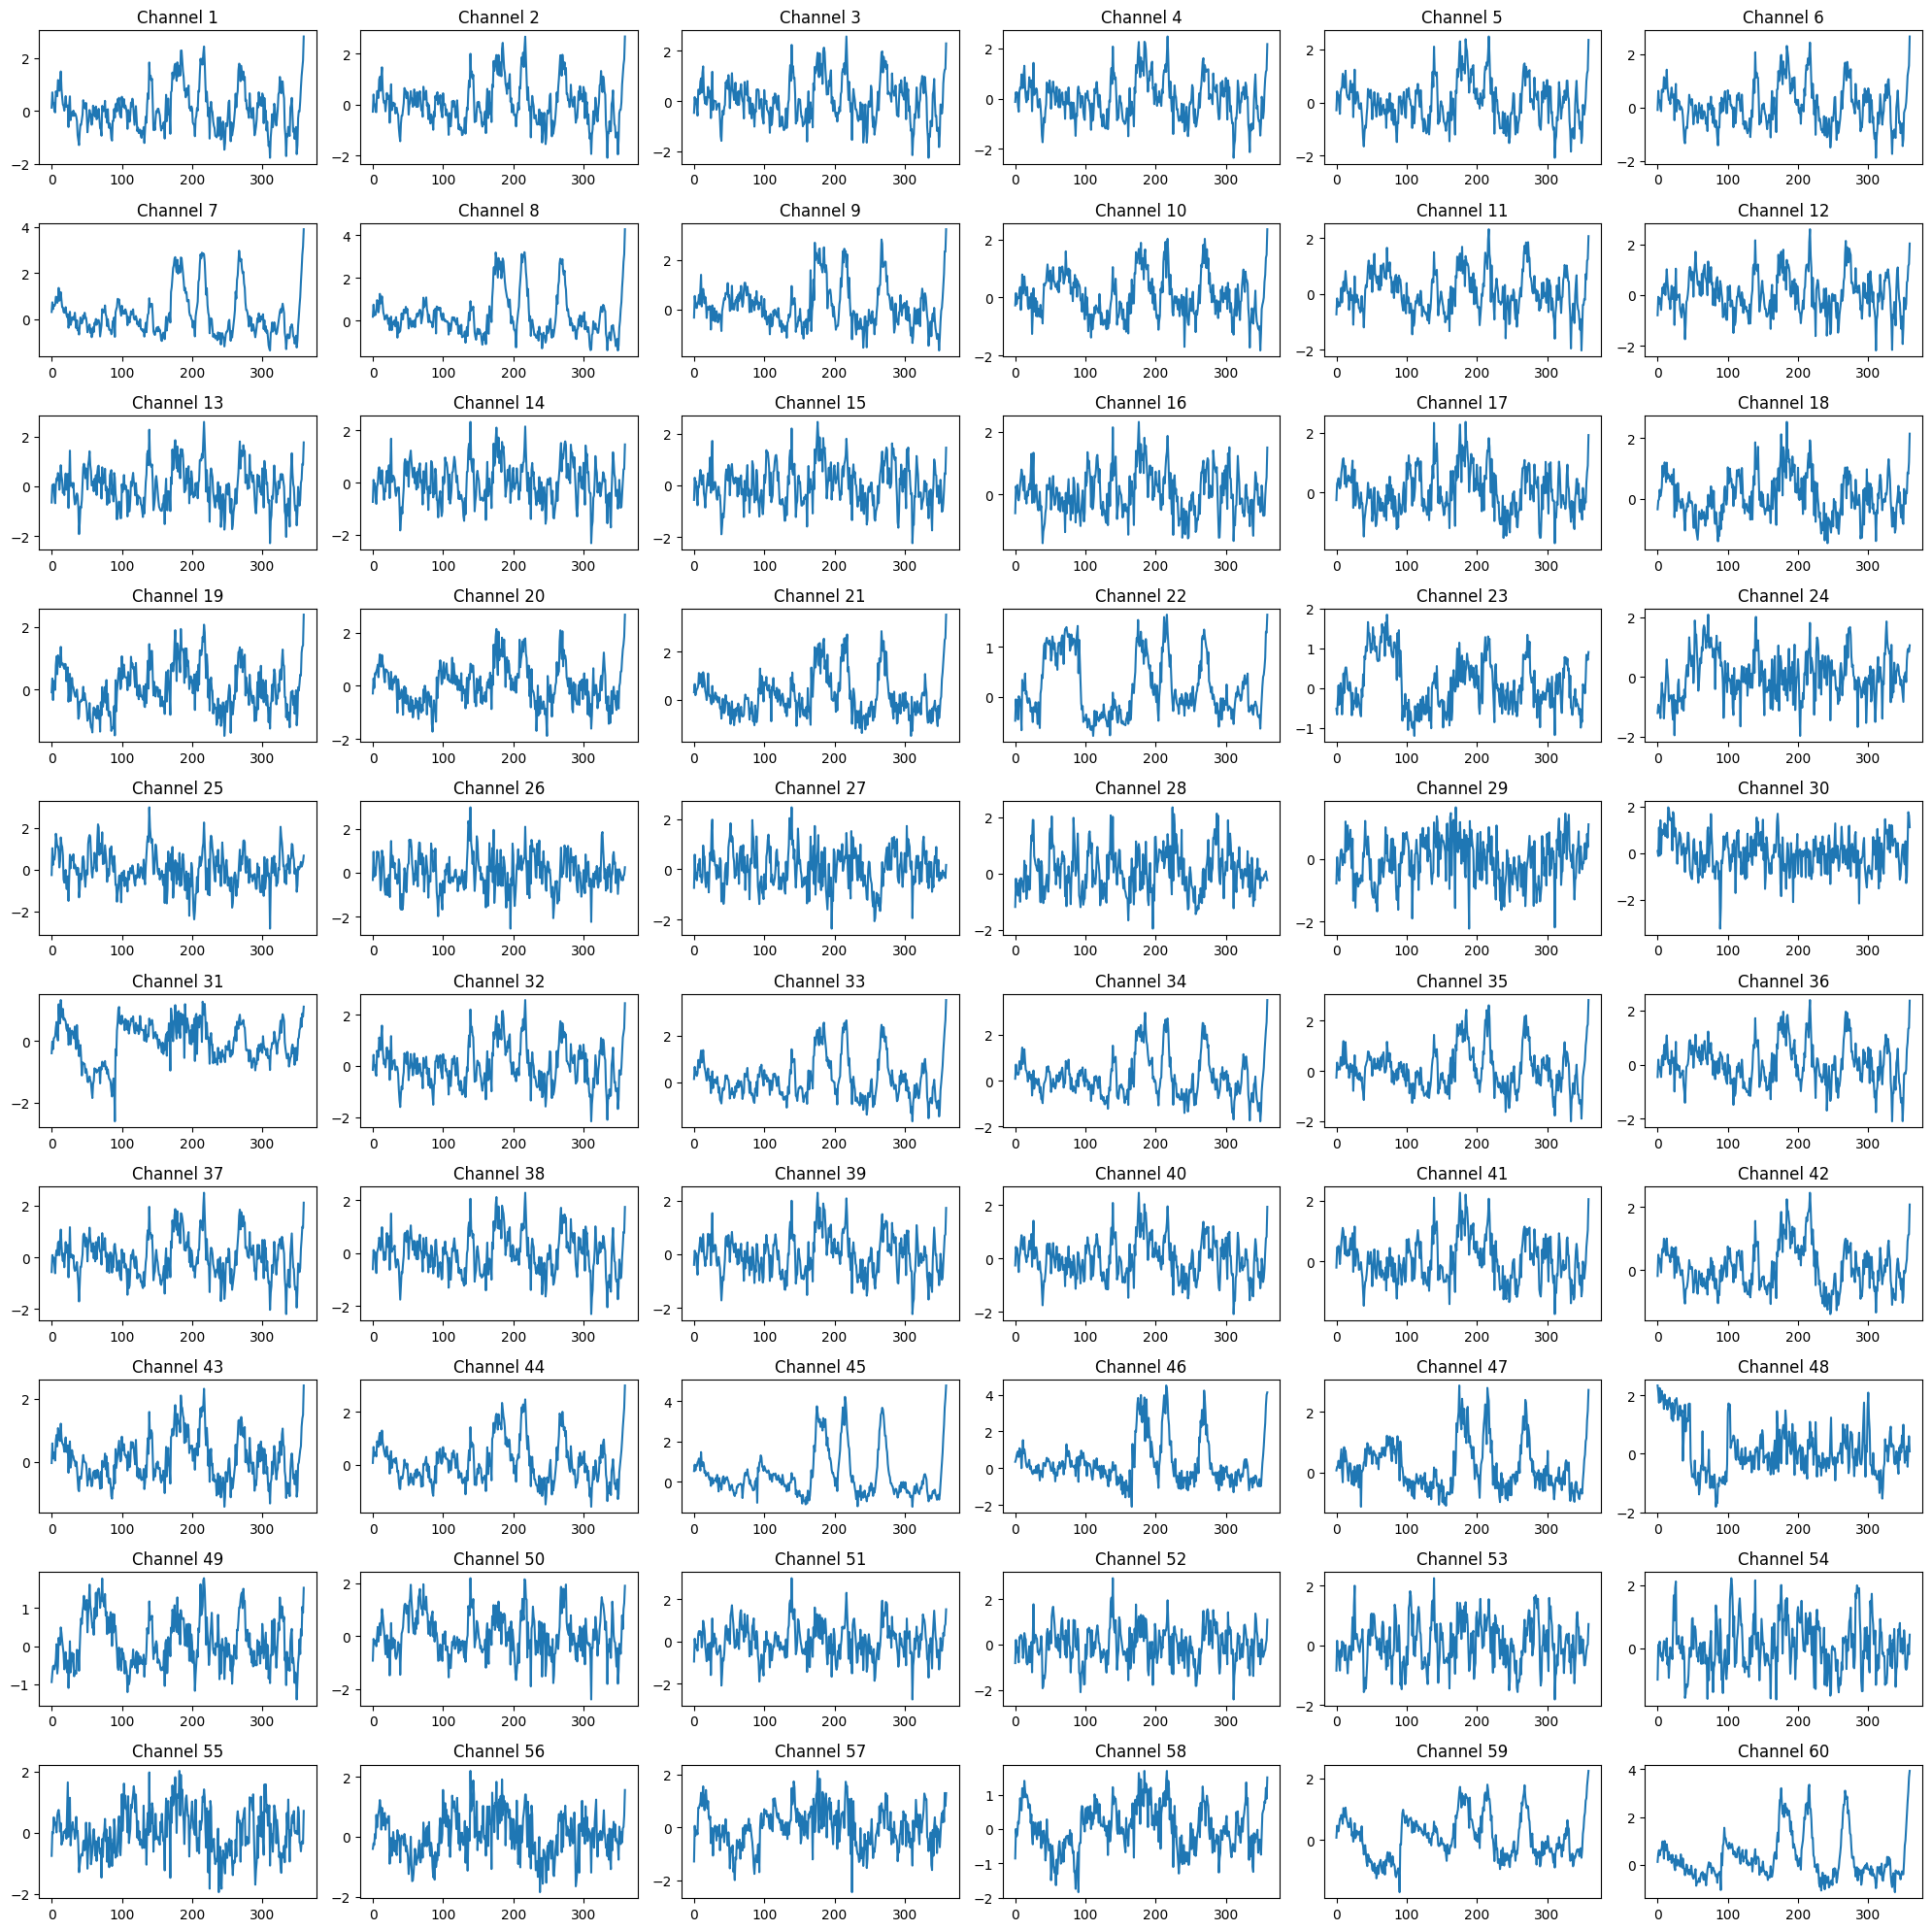

In [29]:
X_scaled = scale_and_clamp(X, dataset.clamp_lim, channel_wise=True)
plot_channels(X_scaled[0].squeeze())

# Audio embedding

- Avg of last 4 activations of wav2vec2.0 

In [25]:
Y = dataset.embed_audio(audio)
print(Y.shape)

torch.Size([2129, 1024, 149])

### Check segments 1 - 40

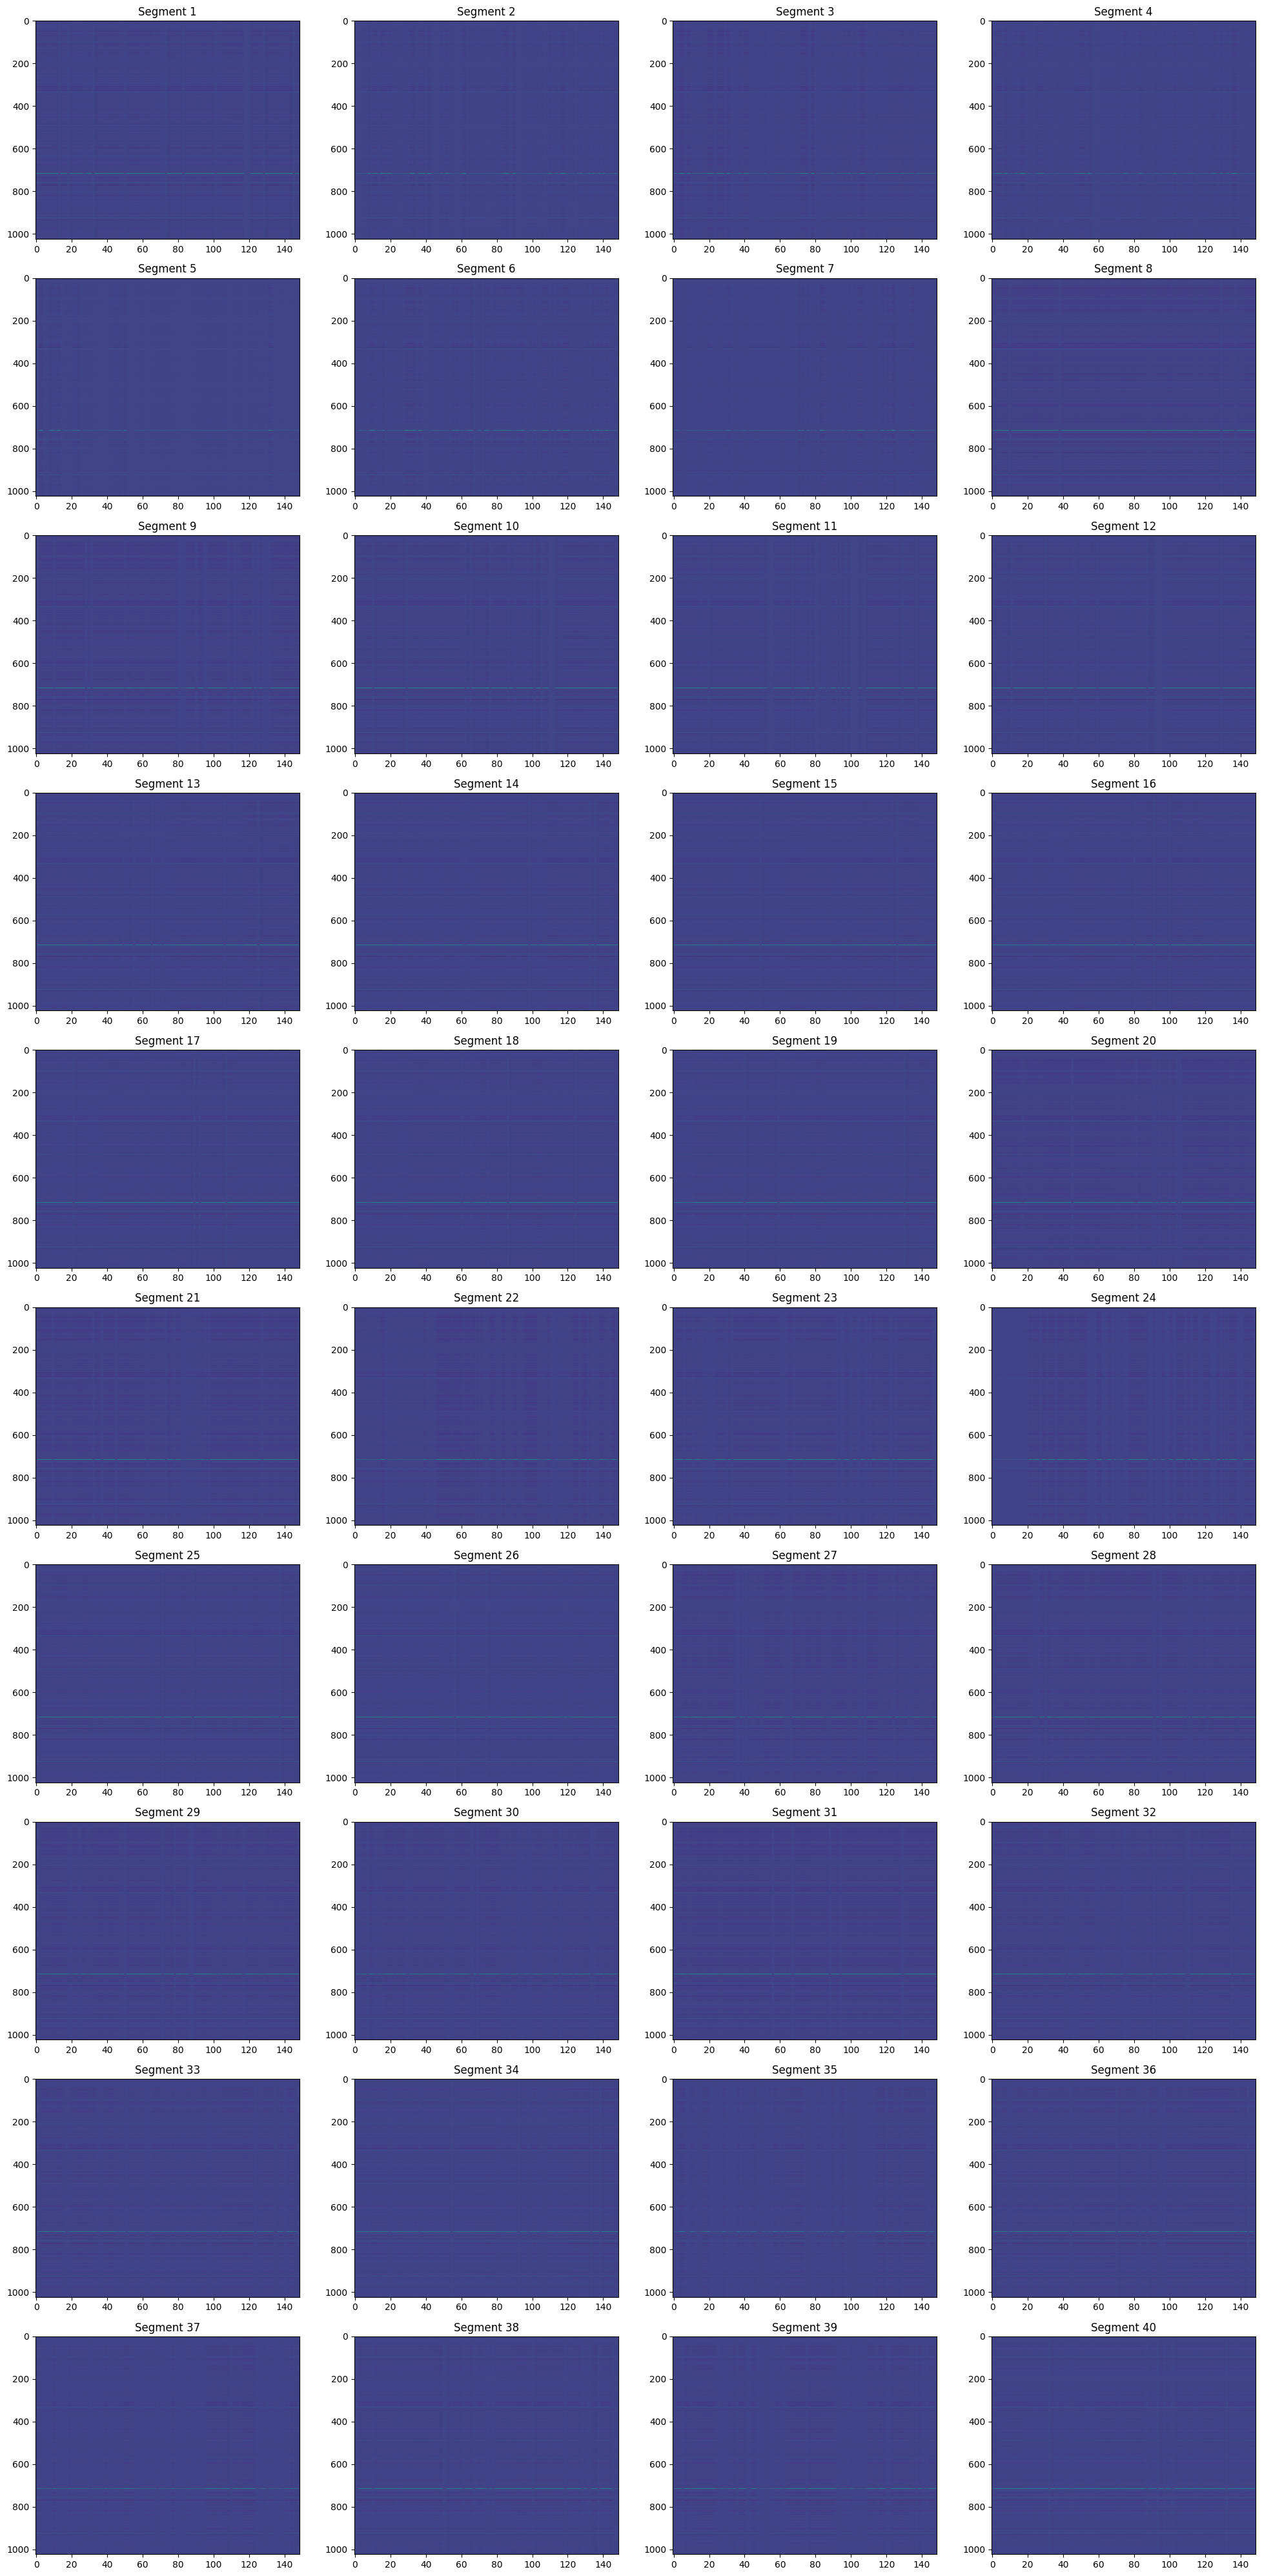

In [38]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(20, 40), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(Y[i], aspect=0.12)
    ax.set_title(f"Segment {i+1}")